# Download and prepare data
Download data from TissueMap instance on pelkmanslab server using Scotts mcu package.

Install needed external packages:
```
pip install git+https://github.com/scottberry/mcu.git
conda install opencv
cd LIBS_DIR
git clone https://github.com/TissueMAPS/TissueMAPS.git
pip install -e --no-deps TissueMaps/tmclient
```

Requires well_names.csv and cell_cycle_classification.csv in DATA_DIR/metadata_raw

In [1]:
from miann_ana.tm_data import get_tm_client, download_channels_metadata, download_wells_metadata
from miann_ana.constants import SOURCE_DIR
from miann.constants import get_data_config
from miann.data import MPPData
import os, shutil
import pandas as pd
from miann.utils import load_config

## NascentRNA dataset

In [2]:
params = load_config(os.path.join(SOURCE_DIR, "scripts/params/download_params.py"))
DATA_CONFIG = get_data_config("NascentRNA")
DATA_DIR = DATA_CONFIG.DATA_DIR

data_dirs = [os.path.join(DATA_DIR, '184A1_unperturbed', well) for well in ['I09', 'I11', 'J10', 'J12']] + \
            [os.path.join(DATA_DIR, '184A1_DMSO', well) for well in ['I14', 'J16']] + \
            [os.path.join(DATA_DIR, '184A1_AZD4573', well) for well in ['I13', 'I17', 'J14', 'J18', 'J21']] + \
            [os.path.join(DATA_DIR, '184A1_CX5461', well) for well in ['I18', 'J09', 'J22']] + \
            [os.path.join(DATA_DIR, '184A1_TSA', well) for well in ['I16', 'J13', 'J20']] + \
            [os.path.join(DATA_DIR, '184A1_triptolide', well) for well in ['I10', 'J15']] + \
            [os.path.join(DATA_DIR, '184A1_meayamycin', well) for well in ['I12', 'I20']] + \
            [os.path.join(DATA_DIR, '184A1_EU10', well) for well in ['H07', 'I08', 'J07']] + \
            [os.path.join(DATA_DIR, '184A1_SBF2', well) for well in ['K18', 'L19', 'M18']] + \
            [os.path.join(DATA_DIR, '184A1_scrambled', well) for well in ['K19', 'L18', 'M19']]

### Downlad channels and wells metadata

In [3]:
tm_client = get_tm_client(params.tm_credentials)
# channels information
download_channels_metadata(tm_client, os.path.join(DATA_DIR, 'channels_metadata.csv'))
# wells information
download_wells_metadata(tm_client, os.path.join(DATA_DIR, 'wells_metadata.csv'), data_dir=DATA_DIR)

### Download mpp data
Downloads mpp data to individual per-well folders with individual metadata.csv files

`scripts/download_mpp.sh`

In [4]:
# move mapobject_ids.npy to obj_ids.npy
for data_dir in data_dirs:
    try:
        shutil.move(os.path.join(data_dir, 'mapobject_ids.npy'), os.path.join(data_dir, "obj_ids.npy"))
    except FileNotFoundError as e:
        print(f"{data_dir} did not find mapobject_ids.npy")

/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_unperturbed/I09 did not find mapobject_ids.npy
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_unperturbed/J10 did not find mapobject_ids.npy
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_unperturbed/J12 did not find mapobject_ids.npy
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_DMSO/I14 did not find mapobject_ids.npy
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_DMSO/J16 did not find mapobject_ids.npy
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_AZD4573/I13 did not find mapobject_ids.npy
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_AZD4573/I17 did not find mapobject_ids.npy
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_AZD4573/J14 did not find mapobject_ids.npy
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_AZ

### Merge metadata.csv with wells metadata and cell cycle classification

In [11]:
cell_cycle = pd.read_csv(os.path.join(DATA_DIR, 'metadata_raw/selected_cells_no_extreme_dapi_cell_cycle_classification.csv'))
wells = pd.read_csv(os.path.join(DATA_DIR, "wells_metadata.csv"), index_col=0)

def merge_metadata(metadata_file):
    metadata = pd.read_csv(metadata_file, index_col=0)
    # ensure that actually updates cell_cycle values 
    if 'cell_cycle' in metadata.columns:
        metadata = metadata.drop(columns=['cell_cycle'])
    df = metadata.merge(cell_cycle, left_on='mapobject_id_cell', right_on='mapobject_id', how='left', suffixes=('','_cc'))
    #df.cell_cycle = df.cell_cycle.fillna("M")
    df = df.drop(columns=[c for c in df.columns if c.endswith('_cc')])
    df = df.merge(wells, left_on='well_name', right_on='well_name', how='left', suffixes=('', '_well'))
    df = df.drop(columns=[c for c in df.columns if c.endswith('_well')])

    df.to_csv(metadata_file)


In [12]:
for data_dir in data_dirs:
    try:
        merge_metadata(os.path.join(data_dir, 'metadata.csv'))
        print(f"{data_dir} updated metadata")
    except FileNotFoundError as e:
        print(f"{data_dir} does not exist")


/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_unperturbed/I09 updated metadata
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_unperturbed/I11 updated metadata
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_unperturbed/J10 does not exist
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_unperturbed/J12 does not exist
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_DMSO/I14 does not exist
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_DMSO/J16 does not exist
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_AZD4573/I13 does not exist
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_AZD4573/I17 does not exist
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_AZD4573/J14 does not exist
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_AZD4573/J18 does not ex

### Add cell crowding feature to metadata
TODO: values are in _CellAggregate folder

In [39]:
#from miann.data import MPPData
#import importlib
#import miann.data
#importlib.reload(miann)
#import miann
#importlib.reload(miann.data._data)

#import miann.utils
#miann.utils.init_logging()

<module 'miann.data._data' from '/Users/hannah.spitzer/projects/pelkmans/software_new/miann/miann/data/_data.py'>

### Add TR value to metadata 
TODO execute once have all data
Compute TR as mean 00_EU value per cell. For replicate wells, compute per-well median TR and overall median TR to normalise per-well TR values:

TR_factor = median_TR / per_well_median_TR
TR_norm = TR * TR_factor

In [8]:
OBJ_ID = DATA_CONFIG.OBJ_ID
def calculate_TR(data_dirs, normalise=False):
    mpp_data = MPPData.concat([MPPData.from_data_dir(d) for d in data_dirs])
    TR = mpp_data.center_mpp[:, list(mpp_data.channels.name).index('00_EU')]

    # calculate per-well TR mean (using overall obj_id TRs -- disregarding cell size!)
    df = pd.DataFrame({'TR': TR, OBJ_ID: mpp_data.obj_ids})
    df_mean_obj = df.groupby(OBJ_ID).mean()
    df_mean_obj = df_mean_obj.merge(mpp_data.metadata[[OBJ_ID, 'well_name']], left_index=True, right_on=OBJ_ID, how='left')
    if normalise:
        # calculate normed TR
        df_median_well = df_mean_obj.groupby('well_name')['TR'].median()
        factors = df_mean_obj['TR'].median() / df_median_well
        # project per-well mean back to obj_id
        df_mean_obj = df_mean_obj.merge(factors, left_on='well_name', right_index=True, how='left', suffixes=('', '_factor'))
        df_mean_obj['TR_norm'] = df_mean_obj['TR'] * df_mean_obj['TR_factor']
    return df_mean_obj

def update_metadata_with_TR(data_dirs, df_mean_obj, normalise=False):
    # write TR, TR_factor, and TR_norm to metadata.csv
    cols = [OBJ_ID, 'TR']
    if normalise:
        cols.extend(['TR_factor', 'TR_norm'])
    for d in data_dirs:
        metadata = pd.read_csv(os.path.join(d, 'metadata.csv'), index_col=0)
        metadata = metadata.merge(df_mean_obj[cols], on=OBJ_ID, how='left', suffixes=('_OLD', ''))
        # remove previous TR values
        metadata = metadata.drop(columns=[c for c in metadata.columns if c.endswith('_OLD')])
        metadata.to_csv(os.path.join(d, 'metadata.csv'))


#### EU10 wells
TR_norm can be used in models trained on only EU10 wells

In [73]:
data_dirs = [os.path.join(DATA_DIR, '184A1_EU10', well) for well in ['H07', 'I08', 'J07']]

df = calculate_TR(data_dirs, normalise=True)
update_metadata_with_TR(data_dirs, df, normalise=True)

# show results
display(df.groupby('well_name')['TR_factor'].first())
_ = df['TR'].hist(by=df['well_name'], sharex=True)
_ = df['TR_norm'].hist(by=df['well_name'], sharex=True)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_hannah_EU10/H07/metadata.csv'

#### Unperturbed wells
TR_norm can be used in models trained on only unperturbed wells

well_name
I09    0.986330
I11    1.008004
Name: TR_factor, dtype: float64

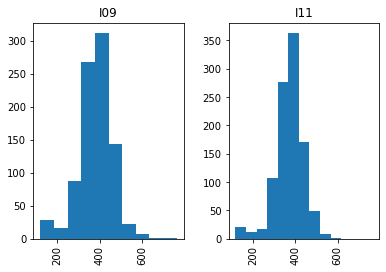

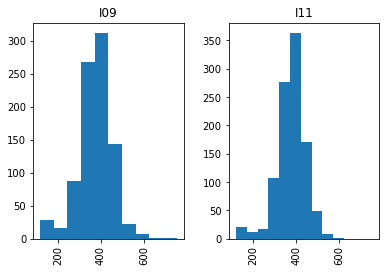

In [9]:
data_dirs = [os.path.join(DATA_DIR, '184A1_unperturbed', well) for well in ['I09', 'I11']] # ['I09', 'I11', 'J10', 'J12']

df = calculate_TR(data_dirs, normalise=True)
update_metadata_with_TR(data_dirs, df, normalise=True)

# show results
display(df.groupby('well_name')['TR_factor'].first())
_ = df['TR'].hist(by=df['well_name'], sharex=True)
_ = df['TR_norm'].hist(by=df['well_name'], sharex=True)

#### SBF2 wells
TR_norm can be used in models trained on only SBF2 wells

In [ ]:
data_dirs =  [os.path.join(DATA_DIR, '184A1_SBF2', well) for well in ['K18', 'L19', 'M18']] + \
              [os.path.join(DATA_DIR, '184A1_scrambled', well) for well in ['K19', 'L18', 'M19']]

df = calculate_TR(data_dirs, normalise=True)
update_metadata_with_TR(data_dirs, df, normalise=True)

# show results
display(df.groupby('well_name')['TR_factor'].first())
_ = df['TR'].hist(by=df['well_name'], sharex=True)
_ = df['TR_norm'].hist(by=df['well_name'], sharex=True)

#### Perturbation wells
only write TR

well_name
I09    0.986330
I11    1.008004
Name: TR_factor, dtype: float64

array([<AxesSubplot:title={'center':'I09'}>,
       <AxesSubplot:title={'center':'I11'}>], dtype=object)

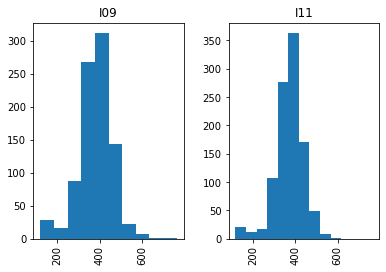

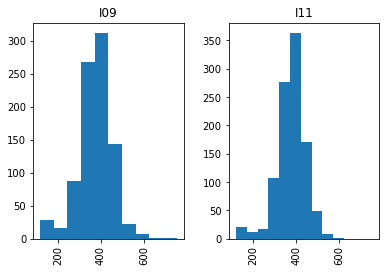

In [91]:
data_dirs = [os.path.join(DATA_DIR, '184A1_DMSO', well) for well in ['I14', 'J16']] + \
            [os.path.join(DATA_DIR, '184A1_AZD4573', well) for well in ['I13', 'I17', 'J14', 'J18', 'J21']] + \
            [os.path.join(DATA_DIR, '184A1_CX5461', well) for well in ['I18', 'J09', 'J22']] + \
            [os.path.join(DATA_DIR, '184A1_TSA', well) for well in ['I16', 'J13', 'J20']] + \
            [os.path.join(DATA_DIR, '184A1_triptolide', well) for well in ['I10', 'J15']] + \
            [os.path.join(DATA_DIR, '184A1_meayamycin', well) for well in ['I12', 'I20']]

df = calculate_TR(data_dirs, normalise=False)
update_metadata_with_TR(data_dirs, df, normalise=False)

# show results
_ = df['TR'].hist(by=df['well_name'], sharex=True, figsize=(10,10))

### Add mean_background to channels_metadata
Read from secondary_only_relative_normalisation, containing background values obtained from empty wells

In [16]:
channels_metadata = pd.read_csv(os.path.join(DATA_DIR, 'channels_metadata.csv'), index_col=0)
bkgrd = pd.read_csv(os.path.join(DATA_DIR, 'metadata_raw', 'secondary_only_relative_normalisation.csv'))

# use non-cell background measurements from HeLa wells as background values per channel
bkgrd = bkgrd.loc[bkgrd['measurement_type'] == "non-cell"].loc[bkgrd['cell_line']== "HeLa"]
bkgrd = bkgrd[['channel','mean_background']].reset_index(drop=True)

# merge bkgrd to channels_metadata
channels_metadata = channels_metadata.merge(bkgrd, how='left', left_on='name', right_on='channel', suffixes=('_OLD', '')).drop(columns=['channel'])
channels_metadata = channels_metadata.drop(columns=[c for c in channels_metadata.columns if c.endswith('_OLD')])
channels_metadata.to_csv(os.path.join(DATA_DIR, 'channels_metadata.csv'))

channels_metadata

,id,name,max_intensity,min_intensity,mean_background
0,3,00_BG488,351,96,109.266166
1,2,00_BG568,349,94,106.990196
2,1,00_DAPI,350,95,107.700000
3,7,00_EU,748,97,NaN
4,8,01_CDK9_pT186,349,94,107.110922
...,...,...,...,...,...
78,79,22_DDX6,853,95,106.578549
79,80,22_DDX6_ILASTIK,63242,0,NaN
80,83,22_H2B,351,96,NaN
81,82,22_NPM1,350,95,107.906872


In [17]:
mpp_data = MPPData.from_data_dir('184A1_unperturbed/I09', data_config='NascentRNA')

In [27]:
channels = pd.read_csv(os.path.join(mpp_data.data_config.DATA_DIR, mpp_data.data_dir, 'channels.csv'), index_col=0, 
names=['channel_id', 'name'])

In [39]:
channels[channels['name'].isin(['00_EU'])].index

Int64Index([0], dtype='int64', name='channel_id')